# Introduction

Two subgroups of code:
1. Featuere Extraction from the Annotations (Data Turk)
1. Train classifiers based on Featuere Extraction.

In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.0


In [2]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt
from importlib import reload
from matplotlib.pyplot import figure
import datetime

# zoomies
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

# custom data loading functions
import load_data
import clean_data
import custom_feature_extraction
import custom_keras_metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from tensorflow.metrics import auc as tf_auc
from tensorflow import local_variables_initializer
import keras
import keras.backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, \
        MaxPooling1D, LSTM, Flatten, BatchNormalization,Embedding,Reshape, Dropout

/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [4]:
annotations ='../data/data_turk/Annotations04-09-19.json'

In [5]:
# reload(load_data)
df = load_data.getJSONData(annotations)
df.head()

,annotation,fileID,text
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...
1,permission_statement,1,i give my permission for photographs/audio/vid...
2,NON_permission_statement.,1,language for required recordings: the research...
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi..."
4,NON_permission_statement.,1,this consent form will be filed securely in an...


### Convert Class Labels

In [6]:
to  = 'label'
field = 'annotation'
    
df[to] = df.apply(lambda row:clean_data.convertAnnotationtoBinary(row, field), axis =1)   

In [7]:
# quick summary of the data 
print('positive class:', df['label'].sum())
print('total: ', len(df))
print('total unique: ', len(set(df['text'])))
print('ratio: ', df['label'].sum()/len(df))

positive class: 873
total:  3923
total unique:  3652
ratio:  0.2225337751720622


In [8]:
maxSeen = 0
for idx, row in df.iterrows():
    if len(row['text']) > maxSeen:
        maxSeen = len(row['text'])
    
print(maxSeen)

1961


# Feature Extraction

### Simple Count Features

In [9]:
# reload(custom_feature_extraction)

In [10]:
df = custom_feature_extraction.getSimpleCounts(df)
df.head()

,annotation,fileID,text,label,char_count,word_count,word_density,punctuation_count
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0,55,12,4.230769,1
1,permission_statement,1,i give my permission for photographs/audio/vid...,1,124,19,6.200000,3
2,NON_permission_statement.,1,language for required recordings: the research...,0,142,20,6.761905,4
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0,144,23,6.000000,7
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0,61,11,5.083333,1


In [11]:
nCores = cpu_count()
print(nCores) # just 4 for my machine

4


### Convert Raw Text to spaCy for more feature extraction

In [12]:
convertFrom = 'text'
convertTo = 'textDOC'

df[convertTo] = dd.from_pandas(df,npartitions=nCores).\
   map_partitions(
      lambda df : df.apply(
         lambda x :clean_data.getDocObjects(x, convertFrom),axis=1)).\
   compute(scheduler='threads')

df.head()

,annotation,fileID,text,label,char_count,word_count,word_density,punctuation_count,textDOC
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0,55,12,4.230769,1,"(a, copy, of, this, entire, consent, form, wil..."
1,permission_statement,1,i give my permission for photographs/audio/vid...,1,124,19,6.200000,3,"(i, give, my, permission, for, photographs, /,..."
2,NON_permission_statement.,1,language for required recordings: the research...,0,142,20,6.761905,4,"(language, for, required, recordings, :, the, ..."
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0,144,23,6.000000,7,"("", (, if, applicable, ,, add, ), information,..."
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0,61,11,5.083333,1,"(this, consent, form, will, be, filed, securel..."


### POS Counts
_"The English part-of-speech tagger uses the OntoNotes 5 version of the Penn Treebank tag set. We also map the tags to the simpler Google Universal POS tag set."_

In [13]:
TAG_MAP = {'PUNCT':1,
           'SYM':2,
           'X':3,
           'CCONJ':4,
           'NUM':5,
           'DET':6,
           'PRON':7,
           'ADP':8,
           'ADJ':9,
           'AUX':10,
           'NOUN':11,
           'PROPN':12,
           'PART':13,
           'ADV':14,
           'SPACE':15,
           'INTJ':16,
           'VERB':17}

In [14]:
def getPOSSeq(row):
    """ get POS counts from textDOC """
    
    TAG_SEQ = []
    for token in row['textDOC'].doc:
        TAG_SEQ.append(TAG_MAP[token.pos_])
        
    return TAG_SEQ
    
df['POS_Seq'] = df.apply(lambda row: getPOSSeq(row), axis=1)

In [15]:
maxTokens = 0
for idx, row in df.iterrows():
    if len(row['POS_Seq']) > maxTokens:
        maxTokens = len(row['POS_Seq'])
    
print(maxTokens)

348


In [16]:
reload(custom_feature_extraction)

<module 'custom_feature_extraction' from '/Users/milk/Desktop/git/permission_statement_extraction/notebooks/custom_feature_extraction.py'>

In [17]:
df = custom_feature_extraction.convertPOSSeqtoOneHot(df, maxTokens)
df.head()

,annotation,fileID,text,label,char_count,word_count,word_density,punctuation_count,textDOC,POS_Seq,...,POS_seq_posi338,POS_seq_posi339,POS_seq_posi340,POS_seq_posi341,POS_seq_posi342,POS_seq_posi343,POS_seq_posi344,POS_seq_posi345,POS_seq_posi346,POS_seq_posi347
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0,55,12,4.230769,1,"(a, copy, of, this, entire, consent, form, wil...","[6, 11, 8, 6, 9, 11, 11, 17, 17, 17, 8, 7, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,permission_statement,1,i give my permission for photographs/audio/vid...,1,124,19,6.200000,3,"(i, give, my, permission, for, photographs, /,...","[7, 17, 9, 11, 8, 11, 2, 11, 2, 11, 11, 13, 17...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NON_permission_statement.,1,language for required recordings: the research...,0,142,20,6.761905,4,"(language, for, required, recordings, :, the, ...","[11, 8, 17, 11, 1, 6, 11, 17, 17, 11, 2, 17, 6...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0,144,23,6.000000,7,"("", (, if, applicable, ,, add, ), information,...","[1, 1, 8, 9, 1, 17, 1, 11, 8, 11, 4, 11, 9, 17...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0,61,11,5.083333,1,"(this, consent, form, will, be, filed, securel...","[6, 11, 11, 17, 17, 17, 14, 8, 6, 9, 11, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sentence Vectors
https://spacy.io/usage/vectors-similarity

[1] Models for the spaCy Natural Language Processing (NLP) library: explosion/spacy-models. Explosion, 2019.

_"English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities."_

In [18]:
# reload(custom_feature_extraction)

df['sent_vec'] = df.apply(lambda row: custom_feature_extraction.getSentenceVectors(row), axis=1)

df.head()

,annotation,fileID,text,label,char_count,word_count,word_density,punctuation_count,textDOC,POS_Seq,...,POS_seq_posi339,POS_seq_posi340,POS_seq_posi341,POS_seq_posi342,POS_seq_posi343,POS_seq_posi344,POS_seq_posi345,POS_seq_posi346,POS_seq_posi347,sent_vec
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0,55,12,4.230769,1,"(a, copy, of, this, entire, consent, form, wil...","[6, 11, 8, 6, 9, 11, 11, 17, 17, 17, 8, 7, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.02983777, 0.017629538, -0.19090748, 0.1045..."
1,permission_statement,1,i give my permission for photographs/audio/vid...,1,124,19,6.200000,3,"(i, give, my, permission, for, photographs, /,...","[7, 17, 9, 11, 8, 11, 2, 11, 2, 11, 11, 13, 17...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.029749835, 0.12945084, -0.16006051, 0.0601..."
2,NON_permission_statement.,1,language for required recordings: the research...,0,142,20,6.761905,4,"(language, for, required, recordings, :, the, ...","[11, 8, 17, 11, 1, 6, 11, 17, 17, 11, 2, 17, 6...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.01512773, 0.047916632, -0.12940559, 0.04827..."
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0,144,23,6.000000,7,"("", (, if, applicable, ,, add, ), information,...","[1, 1, 8, 9, 1, 17, 1, 11, 8, 11, 4, 11, 9, 17...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.064744644, 0.179507, -0.275384, -0.0227434..."
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0,61,11,5.083333,1,"(this, consent, form, will, be, filed, securel...","[6, 11, 11, 17, 17, 17, 14, 8, 6, 9, 11, 1]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0638755, -0.007266668, -0.09555017, 0.10957..."


### Back up
Save a copy so that I can get back to it if I need to... (development hack)

In [19]:
# point in time recovery
backup = df

In [20]:
# # # run this cell in an emergency
# df = backup
# df.head()

### Noun_Chunks

I think thiz may be biased, so I'm experimnenting leaving them out for now.

In [21]:
# df['noun_chunks'] = df.apply(lambda row: custom_feature_extraction.getNounChunks(row), axis=1)
# df.head()

In [22]:
# reload(custom_feature_extraction)

### Convert chunks to one hot

In [23]:
# df = custom_feature_extraction.convertNounChunkstoOneHot(df)
# df.head()

### Convert embeddings to one hot

In [24]:
df = custom_feature_extraction.convertVectoOneHot(df)
df.head()

,annotation,fileID,text,label,char_count,word_count,word_density,punctuation_count,textDOC,POS_Seq,...,vec_posi290,vec_posi291,vec_posi292,vec_posi293,vec_posi294,vec_posi295,vec_posi296,vec_posi297,vec_posi298,vec_posi299
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0,55,12,4.230769,1,"(a, copy, of, this, entire, consent, form, wil...","[6, 11, 8, 6, 9, 11, 11, 17, 17, 17, 8, 7, 1]",...,-0.188510,0.099692,0.020420,-0.105718,0.083448,0.008464,-0.098004,-0.050900,0.005756,0.090207
1,permission_statement,1,i give my permission for photographs/audio/vid...,1,124,19,6.200000,3,"(i, give, my, permission, for, photographs, /,...","[7, 17, 9, 11, 8, 11, 2, 11, 2, 11, 11, 13, 17...",...,-0.236962,0.049824,0.063998,-0.000753,0.165136,-0.012342,0.015370,0.058096,-0.013941,0.123927
2,NON_permission_statement.,1,language for required recordings: the research...,0,142,20,6.761905,4,"(language, for, required, recordings, :, the, ...","[11, 8, 17, 11, 1, 6, 11, 17, 17, 11, 2, 17, 6...",...,-0.271302,0.049614,-0.029253,-0.012151,0.060313,0.046669,-0.020118,-0.032329,-0.010357,0.049174
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0,144,23,6.000000,7,"("", (, if, applicable, ,, add, ), information,...","[1, 1, 8, 9, 1, 17, 1, 11, 8, 11, 4, 11, 9, 17...",...,-0.268256,0.110001,-0.037784,-0.066260,0.008676,-0.105688,-0.123062,-0.156906,0.128169,0.060226
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0,61,11,5.083333,1,"(this, consent, form, will, be, filed, securel...","[6, 11, 11, 17, 17, 17, 14, 8, 6, 9, 11, 1]",...,-0.166543,0.088511,0.055470,-0.265956,0.026951,-0.099905,0.018878,-0.014592,0.047887,0.186848


### Drop Columns 

In [25]:
columns_to_drop = [
    'text',
    'annotation',
    'sent_vec',
    'textDOC',
    'POS_Seq',
]

In [26]:
slim = df.drop(columns_to_drop, axis=1)
slim.head()

,fileID,label,char_count,word_count,word_density,punctuation_count,POS_seq_posi0,POS_seq_posi1,POS_seq_posi2,POS_seq_posi3,...,vec_posi290,vec_posi291,vec_posi292,vec_posi293,vec_posi294,vec_posi295,vec_posi296,vec_posi297,vec_posi298,vec_posi299
0,1,0,55,12,4.230769,1,6,11,8.0,6.0,...,-0.188510,0.099692,0.020420,-0.105718,0.083448,0.008464,-0.098004,-0.050900,0.005756,0.090207
1,1,1,124,19,6.200000,3,7,17,9.0,11.0,...,-0.236962,0.049824,0.063998,-0.000753,0.165136,-0.012342,0.015370,0.058096,-0.013941,0.123927
2,1,0,142,20,6.761905,4,11,8,17.0,11.0,...,-0.271302,0.049614,-0.029253,-0.012151,0.060313,0.046669,-0.020118,-0.032329,-0.010357,0.049174
3,1,0,144,23,6.000000,7,1,1,8.0,9.0,...,-0.268256,0.110001,-0.037784,-0.066260,0.008676,-0.105688,-0.123062,-0.156906,0.128169,0.060226
4,1,0,61,11,5.083333,1,6,11,11.0,17.0,...,-0.166543,0.088511,0.055470,-0.265956,0.026951,-0.099905,0.018878,-0.014592,0.047887,0.186848


### Fill NaNs

In [27]:
slim = slim.fillna(0)
slim.head()

,fileID,label,char_count,word_count,word_density,punctuation_count,POS_seq_posi0,POS_seq_posi1,POS_seq_posi2,POS_seq_posi3,...,vec_posi290,vec_posi291,vec_posi292,vec_posi293,vec_posi294,vec_posi295,vec_posi296,vec_posi297,vec_posi298,vec_posi299
0,1,0,55,12,4.230769,1,6,11,8.0,6.0,...,-0.188510,0.099692,0.020420,-0.105718,0.083448,0.008464,-0.098004,-0.050900,0.005756,0.090207
1,1,1,124,19,6.200000,3,7,17,9.0,11.0,...,-0.236962,0.049824,0.063998,-0.000753,0.165136,-0.012342,0.015370,0.058096,-0.013941,0.123927
2,1,0,142,20,6.761905,4,11,8,17.0,11.0,...,-0.271302,0.049614,-0.029253,-0.012151,0.060313,0.046669,-0.020118,-0.032329,-0.010357,0.049174
3,1,0,144,23,6.000000,7,1,1,8.0,9.0,...,-0.268256,0.110001,-0.037784,-0.066260,0.008676,-0.105688,-0.123062,-0.156906,0.128169,0.060226
4,1,0,61,11,5.083333,1,6,11,11.0,17.0,...,-0.166543,0.088511,0.055470,-0.265956,0.026951,-0.099905,0.018878,-0.014592,0.047887,0.186848


In [28]:
# [print(x) for x in slim.columns]

In [29]:
slim.head()

,fileID,label,char_count,word_count,word_density,punctuation_count,POS_seq_posi0,POS_seq_posi1,POS_seq_posi2,POS_seq_posi3,...,vec_posi290,vec_posi291,vec_posi292,vec_posi293,vec_posi294,vec_posi295,vec_posi296,vec_posi297,vec_posi298,vec_posi299
0,1,0,55,12,4.230769,1,6,11,8.0,6.0,...,-0.188510,0.099692,0.020420,-0.105718,0.083448,0.008464,-0.098004,-0.050900,0.005756,0.090207
1,1,1,124,19,6.200000,3,7,17,9.0,11.0,...,-0.236962,0.049824,0.063998,-0.000753,0.165136,-0.012342,0.015370,0.058096,-0.013941,0.123927
2,1,0,142,20,6.761905,4,11,8,17.0,11.0,...,-0.271302,0.049614,-0.029253,-0.012151,0.060313,0.046669,-0.020118,-0.032329,-0.010357,0.049174
3,1,0,144,23,6.000000,7,1,1,8.0,9.0,...,-0.268256,0.110001,-0.037784,-0.066260,0.008676,-0.105688,-0.123062,-0.156906,0.128169,0.060226
4,1,0,61,11,5.083333,1,6,11,11.0,17.0,...,-0.166543,0.088511,0.055470,-0.265956,0.026951,-0.099905,0.018878,-0.014592,0.047887,0.186848


### Training Data Split


In [30]:
train, test = train_test_split(slim,
                               stratify=slim['label'],
                               test_size=0.3, 
                               random_state=1729)

In [31]:
y_train = train['label']
y_test = test['label']

X_train = train.drop(['label', 'fileID'], axis=1)
X_test = test.drop(['label', 'fileID'], axis=1)

In [32]:
print(sum(y_train))
print(len(y_train))
print(sum(y_train)/len(y_train))

611
2746
0.22250546249089584


### SMOTE

###### NOTE:  This has not been shown to be necessary, as the instances of the postive classification are numerous enough (empirically) to be able to converge ML models.

Citation:
[1] N. V. Chawla, K. W. Bowyer, L. O. Hall, and W. P. Kegelmeyer, “SMOTE: Synthetic Minority Over-sampling Technique,” 1, vol. 16, pp. 321–357, Jun. 2002.

_"method of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance (in ROC space) than only under-sampling the majority class. This paper also shows that a combination of our method of over-sampling the minority class and under-sampling the majority class can achieve better classifier performance (in ROC space) than varying the loss ratios in Ripper or class priors in Naive Bayes. Our method of over-sampling the minority class involves creating synthetic minority class examples."_

In [33]:
sm = SMOTE(random_state=1729, ratio = 1)
X_train, y_train = sm.fit_sample(X_train, y_train)
print(sum(y_train))
print(len(y_train))
print(sum(y_train)/len(y_train))

2135
4270
0.5


## Baseline Classifiers

In [34]:
models = []

models.append(("KNeighbors",
               KNeighborsClassifier(weights='distance')))

models.append(("LogisticRegression",
               LogisticRegression(solver='liblinear',
                                  max_iter=1000000,
                                  class_weight={1:.21},
                                  penalty='l1')))

dtBase = DecisionTreeClassifier(max_depth=10, 
                               max_features=9,
                               class_weight={1:.2})

models.append(("DecisionTree",dtBase))

rdfBase = RandomForestClassifier(n_estimators=1000,
                                class_weight={1:.2})

models.append(("RandomForest",rdfBase))


rf2 = RandomForestClassifier(n_estimators=1000, 
                             criterion='gini',
                             max_depth=10,
                             class_weight={1:.2})

models.append(("RandomForest-2",rf2))

models.append(("BaggingClassifier",
               BaggingClassifier(DecisionTreeClassifier(max_depth=3),
                                n_estimators=100,
                                max_features=9)))

models.append(("BaggingClassifier-2",
               BaggingClassifier(dtBase,
                                n_estimators=100,
                                max_features=9)))

models.append(("AdaBoostClassifier",
               AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                                  algorithm="SAMME",
                                  n_estimators=100)))

models.append(("GradientBoostingClassifier",
               GradientBoostingClassifier(n_estimators=100, 
                                          max_leaf_nodes=4, 
                                          max_depth = 10)))

In [35]:
result_rows = []
count = 1
results_frame = pd.DataFrame()

predictionsList = []
fitted_models = []

for name, model in models:
    model.fit(X_train, y_train)
    
    # store models in a list, in case we want 'em again
    fitted_models.append((name, model))
    
    # get predictions
    prediction_vec = model.predict(X_test)
    
    # save predictions - useful for further ensemble methods/voters
    predictionsList.append((name, prediction_vec))
    
#     # print a classifaction report for each model
#     report = classification_report(y_test, prediction_vec)
#     print(' #### ', name, '\n', report, '\n')
    
    # store result in data frame
    results_frame.loc[count, 'Model'] = name
    results_frame.loc[count, 'Accuracy'] = accuracy_score(y_test, prediction_vec)
    results_frame.loc[count, 'Precision'] = precision_score(y_test, prediction_vec)
    results_frame.loc[count, 'AUCROC'] = roc_auc_score(y_test, prediction_vec)
    
    print(name, "roc: ", roc_auc_score(y_test, prediction_vec))

    # increment data frame 
    count = count + 1

KNeighbors roc:  0.5688754014933467
LogisticRegression roc:  0.6643494764943895
DecisionTree roc:  0.5657614816668752
RandomForest roc:  0.7885892462353481
RandomForest-2 roc:  0.6635506611604721
BaggingClassifier roc:  0.7285049847745381
BaggingClassifier-2 roc:  0.5051787427522629
AdaBoostClassifier roc:  0.7798711049931173
GradientBoostingClassifier roc:  0.7550285738122055


In [36]:
# add majority class classifier for base-line comparison
majority_class = np.zeros(len(y_test))

ac = accuracy_score(y_test, majority_class)
pr = precision_score(y_test, majority_class)
roc = roc_auc_score(y_test, majority_class)

results_frame.loc[count, 'Model'] = 'Naive Baseline - MajorityClassClassifier'
results_frame.loc[count, 'Accuracy'] = ac
results_frame.loc[count, 'Precision'] = pr
results_frame.loc[count, 'AUCROC'] = roc

count = count + 1

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
results_frame.head(len(results_frame))

,Model,Accuracy,Precision,AUCROC
1,KNeighbors,0.480034,0.260929,0.568875
2,LogisticRegression,0.827528,0.718519,0.664349
3,DecisionTree,0.697536,0.323308,0.565761
4,RandomForest,0.842821,0.635088,0.788589
5,RandomForest-2,0.836873,0.807018,0.663551
6,BaggingClassifier,0.762107,0.475543,0.728505
7,BaggingClassifier-2,0.779099,0.750000,0.505179
8,AdaBoostClassifier,0.841971,0.638686,0.779871
9,GradientBoostingClassifier,0.813934,0.572391,0.755029
10,Naive Baseline - MajorityClassClassifier,0.777400,0.000000,0.500000


## Neural Network (to migrate to models)
Neural Network Classifier Code (keras). No Need for it now, but may be useful in the event that BERT training time is too costly.

In [38]:
print(X_train.shape[1])
print(X_test.shape)

652
(1177, 652)


In [39]:
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [40]:
dim = X_train.shape[1]

# Create model
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=dim))
model.add(Dense(units=500, activation='softmax'))
# model.add(Conv1D(128, 5, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=500, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
              optimizer=keras.optimizers.Adagrad(lr=0.001), 
              metrics=['accuracy', 
                       custom_keras_metrics.keras_precision, 
                       custom_keras_metrics.keras_recall, 
                       custom_keras_metrics.keras_auc])

# Train
mod = model.fit(X_train, 
                y_train,
                validation_data=(X_test,y_test), 
                epochs=25,
                batch_size=3,
                shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 4270 samples, validate on 1177 samples
Epoch 1/25
4270/4270 [==============================] - 5s 1ms/step - loss: 0.6938 - acc: 0.4974 - keras_precision: 0.4974 - keras_recall: 0.4974 - keras_auc: 0.4989 - val_loss: 0.6942 - val_acc: 0.2226 - val_keras_precision: 0.2226 - val_keras_recall: 0.2226 - val_keras_auc: 0.4939
Epoch 2/25
4270/4270 [==============================] - 5s 1ms/step - loss: 0.6930 - acc: 0.5197 - keras_precision: 0.5197 - keras_recall: 0.5197 - keras_auc: 0.4980 - val_loss: 0.6944 - val_acc: 0.2982 - val_keras_precision: 0.2982 - val_keras_recall: 0.2982 - val_keras_auc: 0.5009
Epoch 3/25
4270/4270 [==============================] - 5s 1ms/step - loss: 0.6924 - acc: 0.5410 - keras_precision: 0.5410 - keras_recall:

In [41]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               65300     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              11000     
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1002      
Total params: 633,312
Trainable params: 633,312
Non-trainable params: 0
_________________________________________________________________
None

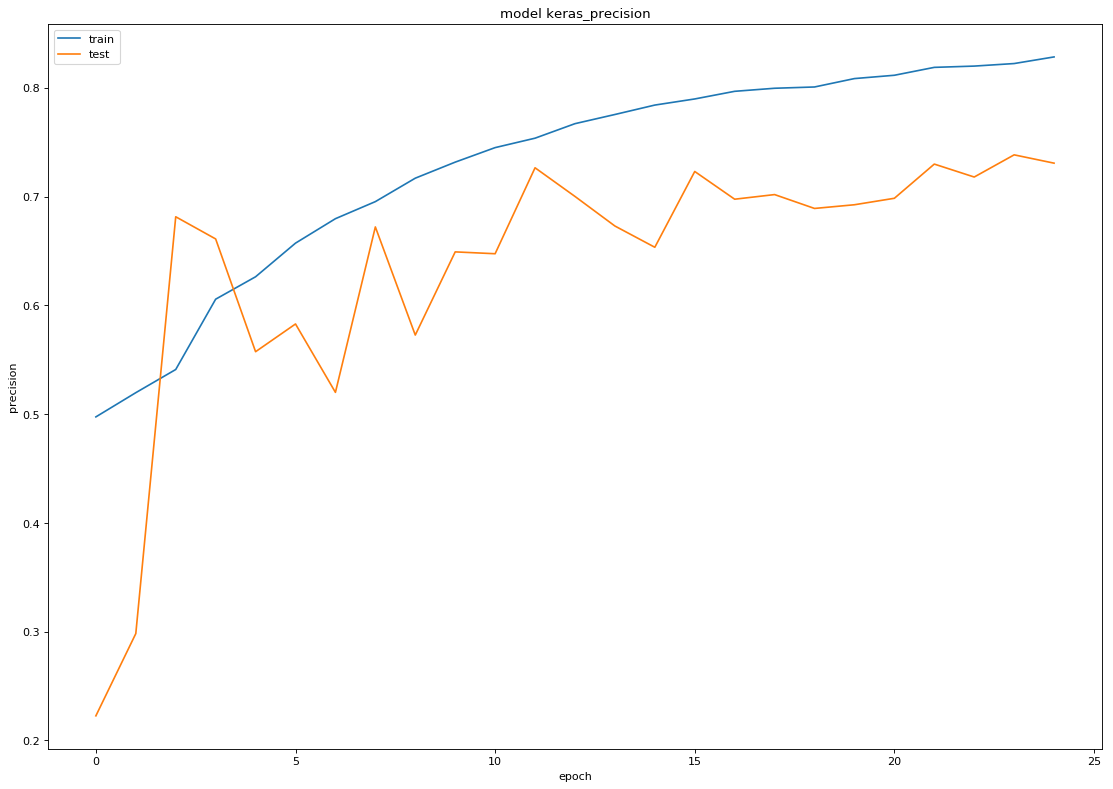

In [42]:
%matplotlib inline

figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

plt.plot(mod.history['keras_precision'])
plt.plot(mod.history['val_keras_precision'])
plt.title('model keras_precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

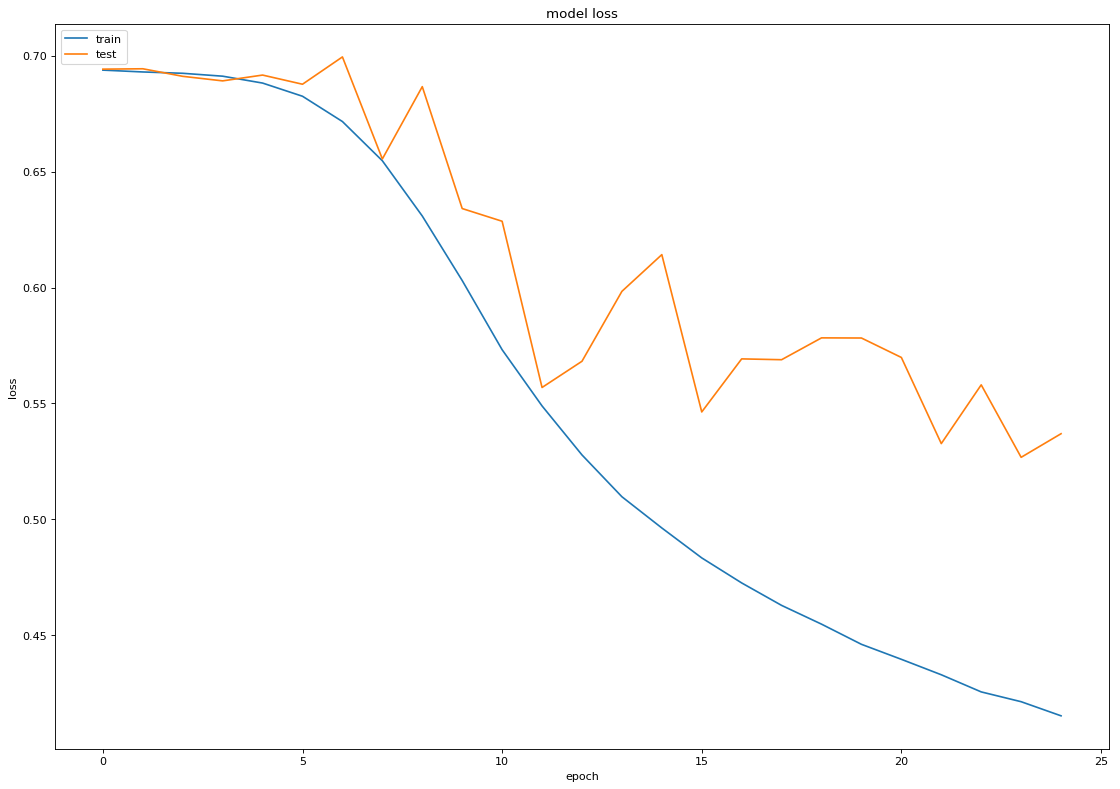

In [43]:
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
results_frame.loc[count, 'Model'] = 'Simple ANN'
results_frame.loc[count, 'Accuracy'] = mod.history['val_acc'][-1]
results_frame.loc[count, 'Precision'] = mod.history['val_keras_precision'][-1]
results_frame.loc[count, 'AUCROC'] = mod.history['val_keras_auc'][-1]

results_frame.head(len(results_frame))

,Model,Accuracy,Precision,AUCROC
1,KNeighbors,0.480034,0.260929,0.568875
2,LogisticRegression,0.827528,0.718519,0.664349
3,DecisionTree,0.697536,0.323308,0.565761
4,RandomForest,0.842821,0.635088,0.788589
5,RandomForest-2,0.836873,0.807018,0.663551
6,BaggingClassifier,0.762107,0.475543,0.728505
7,BaggingClassifier-2,0.779099,0.750000,0.505179
8,AdaBoostClassifier,0.841971,0.638686,0.779871
9,GradientBoostingClassifier,0.813934,0.572391,0.755029
10,Naive Baseline - MajorityClassClassifier,0.777400,0.000000,0.500000


### save the model

In [45]:
today = str(datetime.date.today())

# serialize model to YAML
model_yaml = model.to_yaml()
with open("../models/feature_based_ANN_model" + today + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("../models/feature_based_ANN_model" + today + ".h5")
print("Saved model to disk")

Saved model to disk


### Second NN Design

### A different convolutional approach
Can't use SMOTE, we'll be working with Keras embeddings and LTSM.

In [46]:
slim2 = df[['label', 'text']]
slim2.head()

,label,text
0,0,a copy of this entire consent form will be giv...
1,1,i give my permission for photographs/audio/vid...
2,0,language for required recordings: the research...
3,0,"""(if applicable, add) information about indivi..."
4,0,this consent form will be filed securely in an...


In [47]:
vocabulary_size = 1000
maxlen = 100

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(slim2['text'])
sequences = tokenizer.texts_to_sequences(slim2['text'])
data = pad_sequences(sequences, maxlen=maxlen)

In [48]:
slim2['data'] = data.tolist()
slim2['data'].head(10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: data, dtype: object

In [49]:
new_col_names = ['seq_posi' + str(i) for i in range(0,maxlen)]
pos_seq_df = pd.DataFrame(slim2['data'].values.tolist(), columns=new_col_names)
slim2 = pd.concat([slim2, pos_seq_df], axis=1)
slim2.head()

,label,text,data,seq_posi0,seq_posi1,seq_posi2,seq_posi3,seq_posi4,seq_posi5,seq_posi6,...,seq_posi90,seq_posi91,seq_posi92,seq_posi93,seq_posi94,seq_posi95,seq_posi96,seq_posi97,seq_posi98,seq_posi99
0,0,a copy of this entire consent form will be giv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,3,9,609,19,27,13,8,52,2,87
1,1,i give my permission for photographs/audio/vid...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,247,3,87,117,29,107,7,9,17,11
2,0,language for required recordings: the research...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,795,4,6,844,117,1,11,226,16,194
3,0,"""(if applicable, add) information about indivi...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,197,5,31,95,691,13,8,52,2,5
4,0,this consent form will be filed securely in an...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,0,0,9,19,27,13,8,7,61,638


In [50]:
text_train, text_test = train_test_split(slim2,
                               stratify=slim2['label'],
                               test_size=0.3, 
                               random_state=1729)

text_train.head()

,label,text,data,seq_posi0,seq_posi1,seq_posi2,seq_posi3,seq_posi4,seq_posi5,seq_posi6,...,seq_posi90,seq_posi91,seq_posi92,seq_posi93,seq_posi94,seq_posi95,seq_posi96,seq_posi97,seq_posi98,seq_posi99
370,1,the research team will know your identity and ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,12,505,4,16,5,26,7,1,17,11
3400,0,"""veteran s administration insurance i select v...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,25,174,949,91,30,7,279,2,29,407
2715,1,initials [ks43] expiration of your authorizati...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,84,13,18,879,208,45,20,15,17,11
1664,0,please read the information below and ask ques...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,124,4,115,94,42,16,5,49,18,66
961,1,"""i have read this consent form and agree to be...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,...,31,1,747,16,22,23,221,46,25,57


In [51]:
label_train = keras.utils.to_categorical(text_train['label'], num_classes=2)
label_test = keras.utils.to_categorical(text_test['label'], num_classes=2)

In [53]:
model2 = Sequential()
model2.add(Embedding(vocabulary_size, 100, input_length=maxlen))
model2.add(Dropout(0.2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=4))
model2.add(LSTM(100))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
                metrics=['accuracy', 
                    custom_keras_metrics.keras_precision, 
                    custom_keras_metrics.keras_recall, 
                    custom_keras_metrics.keras_auc])

mod2 = model2.fit(text_train[new_col_names], 
                  label_train, 
                  validation_data=(text_test[new_col_names],label_test), 
#                   validation_split=0.3, 
                  epochs=25,
                  shuffle=True,
                  batch_size=3)

Train on 2746 samples, validate on 1177 samples
Epoch 1/25
2746/2746 [==============================] - 26s 9ms/step - loss: 0.4053 - acc: 0.8212 - keras_precision: 0.8212 - keras_recall: 0.8212 - keras_auc: 0.8720 - val_loss: 0.3463 - val_acc: 0.8437 - val_keras_precision: 0.8437 - val_keras_recall: 0.8437 - val_keras_auc: 0.9037
Epoch 2/25
2746/2746 [==============================] - 24s 9ms/step - loss: 0.2600 - acc: 0.8951 - keras_precision: 0.8951 - keras_recall: 0.8951 - keras_auc: 0.9221 - val_loss: 0.3137 - val_acc: 0.8683 - val_keras_precision: 0.8683 - val_keras_recall: 0.8683 - val_keras_auc: 0.9324
Epoch 3/25
2746/2746 [==============================] - 24s 9ms/step - loss: 0.1833 - acc: 0.9253 - keras_precision: 0.9253 - keras_recall: 0.9253 - keras_auc: 0.9417 - val_loss: 0.3236 - val_acc: 0.8726 - val_keras_precision: 0.8726 - val_keras_recall: 0.8726 - val_keras_auc: 0.9469
Epoch 4/25
2746/2746 [==============================] - 23s 8ms/step - loss: 0.1188 - acc: 0.9534

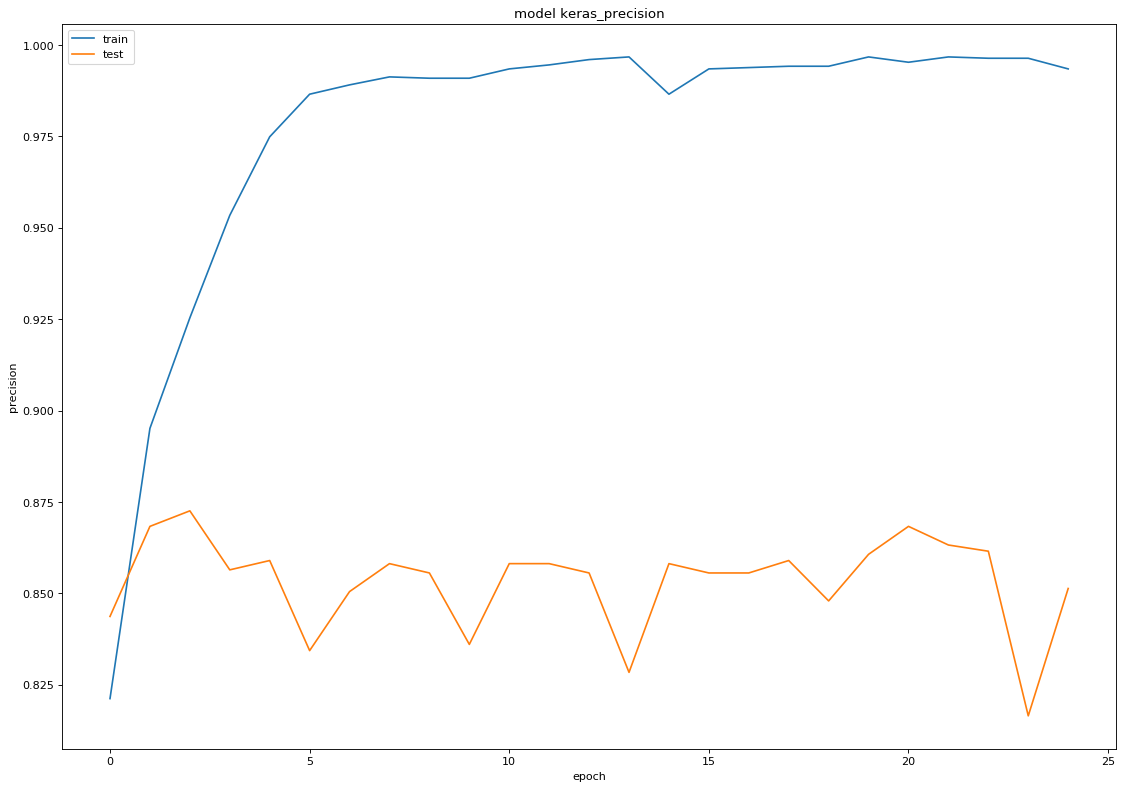

In [54]:
%matplotlib inline
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

plt.plot(mod2.history['keras_precision'])
plt.plot(mod2.history['val_keras_precision'])
plt.title('model keras_precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
count += 1
results_frame.loc[count, 'Model'] = 'CNN'
results_frame.loc[count, 'Accuracy'] = mod2.history['val_acc'][-1]
results_frame.loc[count, 'Precision'] = mod2.history['val_keras_precision'][-1]
results_frame.loc[count, 'AUCROC'] = mod2.history['val_keras_auc'][-1]

results_frame.head(len(results_frame))

,Model,Accuracy,Precision,AUCROC
1,KNeighbors,0.480034,0.260929,0.568875
2,LogisticRegression,0.827528,0.718519,0.664349
3,DecisionTree,0.697536,0.323308,0.565761
4,RandomForest,0.842821,0.635088,0.788589
5,RandomForest-2,0.836873,0.807018,0.663551
6,BaggingClassifier,0.762107,0.475543,0.728505
7,BaggingClassifier-2,0.779099,0.750000,0.505179
8,AdaBoostClassifier,0.841971,0.638686,0.779871
9,GradientBoostingClassifier,0.813934,0.572391,0.755029
10,Naive Baseline - MajorityClassClassifier,0.777400,0.000000,0.500000


In [56]:
# serialize model to YAML
model_yaml = model2.to_yaml()
with open("../models/CNN_model" + today + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model2.save_weights("../models/CNN_model" + today + ".h5")
print("Saved model to disk")

Saved model to disk
